In [9]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline
import pickle


df = pd.read_csv('Train.csv')

In [12]:
# load data
df = pd.read_csv('Train.csv')

# Rename kolom 
df = df.rename(columns={'Warehouse_block':'Warehouse',
                        'Mode_of_Shipment':'Shipment',
                        'Customer_care_calls':'Calls',
                        'Customer_rating':'Rating',
                        'Cost_of_the_Product':'Cost',
                        'Prior_purchases':'Purchases',
                        'Product_importance':'Importance',
                        'Discount_offered':'Discount',
                        'Weight_in_gms':'Weight (gram)',
                        'Reached.on.Time_Y.N':'Late'})

In [14]:
# Perform one-hot encoding for 'Shipment' and 'Warehouse' features
df = pd.get_dummies(df, columns=['Shipment', 'Warehouse'])


In [16]:
def categorize_purchases(Purchases):
    if Purchases >= 3:
        return 1
    else:
        return 0

df['Reorder_purchases'] = df['Purchases'].apply(categorize_purchases) 
#pengambilan data reorder purchases diambil dari dataset df karena data purchase sudah terkena robust scaling

# Menampilkan kolom 'Purchases' dan 'Reorder_purchase'
print(df[['Purchases', 'Reorder_purchases']])


       Purchases  Reorder_purchases
0              3                  1
1              2                  0
2              4                  1
3              4                  1
4              3                  1
...          ...                ...
10994          5                  1
10995          5                  1
10996          5                  1
10997          6                  1
10998          5                  1

[10999 rows x 2 columns]


In [20]:
# Drop the columns 'ID', 'Calls', 'Rating', and 'Gender'
df.drop(columns=['ID', 'Calls', 'Rating', 'Gender'], inplace=True)

In [24]:
# Export the modified DataFrame to a CSV file
df.to_csv('uji_dataset_10999.csv', index=False)

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10999 entries, 0 to 10998
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   Cost               10999 non-null  int64
 1   Purchases          10999 non-null  int64
 2   Importance         10999 non-null  int64
 3   Discount           10999 non-null  int64
 4   Weight (gram)      10999 non-null  int64
 5   Late               10999 non-null  int64
 6   Shipment_Flight    10999 non-null  int64
 7   Shipment_Road      10999 non-null  int64
 8   Shipment_Ship      10999 non-null  int64
 9   Warehouse_A        10999 non-null  int64
 10  Warehouse_B        10999 non-null  int64
 11  Warehouse_C        10999 non-null  int64
 12  Warehouse_D        10999 non-null  int64
 13  Warehouse_F        10999 non-null  int64
 14  Reorder_purchases  10999 non-null  int64
dtypes: int64(15)
memory usage: 1.3 MB


In [22]:
# Convert all boolean columns to integers
df = df.astype({col: 'int' for col in df.select_dtypes('bool').columns})

In [18]:
mapping_Importance = {
    'low': 0,
    'medium': 1,
    'high': 2,
}

# Map the 'Importance' column
df['Importance'] = df['Importance'].map(mapping_Importance)


In [4]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

# DATA
X = df.drop('Late', axis=1)
y = df['Late']

# Split data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Columns to be scaled
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col not in ['Reorder_purchases', 'Shipment_Flight', 'Shipment_Road', 'Shipment_Ship', 'Warehouse_A', 'Warehouse_B', 'Warehouse_C', 'Warehouse_D', 'Warehouse_F']]

# Create transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        # Adding the already one-hot encoded columns
        ('cat', 'passthrough', ['Reorder_purchases', 'Shipment_Flight', 'Shipment_Road', 'Shipment_Ship', 'Warehouse_A', 'Warehouse_B', 'Warehouse_C', 'Warehouse_D', 'Warehouse_F'])
    ])

# Create pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        ccp_alpha=0, 
        max_depth=79, 
        max_features='sqrt',
        min_samples_leaf=83, 
        min_samples_split=100
    ))
])

# Fit pipeline
pipeline.fit(x_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['Cost', 'Purchases',
                                                   'Importance', 'Discount',
                                                   'Weight (gram)']),
                                                 ('cat', 'passthrough',
                                                  ['Reorder_purchases',
                                                   'Shipment_Flight',
                                                   'Shipment_Road',
                                                   'Shipment_Ship',
                                                   'Warehouse_A', 'Warehouse_B',
                                                   'Warehouse_C', 'Warehouse_D',
                                                   'Warehouse_F'])])),
                ('classifier',
                 DecisionTreeClassifier(ccp_alpha=0, max_depth=79,
                                        max_features='sqrt',
                                        min_samples_leaf=83,
                                        min_samples_split=100))])

In [6]:
from joblib import dump, load

# Save the pipeline and the optimal threshold
dump((pipeline), "model_dt_new.joblib")


['model_dt_new.joblib']

In [25]:
from joblib import dump, load

# Load the pipeline and the optimal threshold and make predictions
loaded_pipeline= load("model_dt_new.joblib")

new_data = pd.read_csv('uji_dataset_10999.csv')


if 'Late' in new_data.columns:
    new_data = new_data.drop('Late', axis=1)


predictions = loaded_pipeline.predict(new_data)

# Menambahkan kolom prediksi ke dataset
new_data['Predicted_Late'] = predictions



In [10]:
new_data.sample(10)

,Cost,Purchases,Importance,Discount,Weight (gram),Shipment_Flight,Shipment_Road,Shipment_Ship,Warehouse_A,Warehouse_B,Warehouse_C,Warehouse_D,Warehouse_F,Reorder_purchases,Predicted_Late
4055,258,3,2,1,4653,0,0,1,0,0,0,1,0,1,0
3295,181,2,1,2,4089,0,0,1,0,0,0,1,0,0,1
7507,181,3,0,4,4399,1,0,0,0,0,1,0,0,1,0
7864,225,2,0,2,4520,0,0,1,0,0,0,0,1,0,1
6501,178,8,1,6,4146,0,0,1,0,1,0,0,0,1,0
4680,177,4,0,8,5878,0,0,1,0,0,0,0,1,1,0
2386,246,2,1,31,2415,0,1,0,0,0,0,0,1,0,1
7723,301,4,1,1,1966,0,0,1,0,0,1,0,0,1,0
3206,252,2,0,4,5559,0,0,1,0,0,0,0,1,0,0
3415,249,2,1,3,4440,0,0,1,0,0,0,1,0,0,1


Confusion Matrix:
[[3063 1297]
 [2341 3941]]

Total predictions: 10642
Correct predictions: 7004 (65.81%)
Incorrect predictions: 3638 (34.19%)
On-time Delivery Rate: 70.25%

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.70      0.63      4360
           1       0.75      0.63      0.68      6282

    accuracy                           0.66     10642
   macro avg       0.66      0.66      0.66     10642
weighted avg       0.68      0.66      0.66     10642



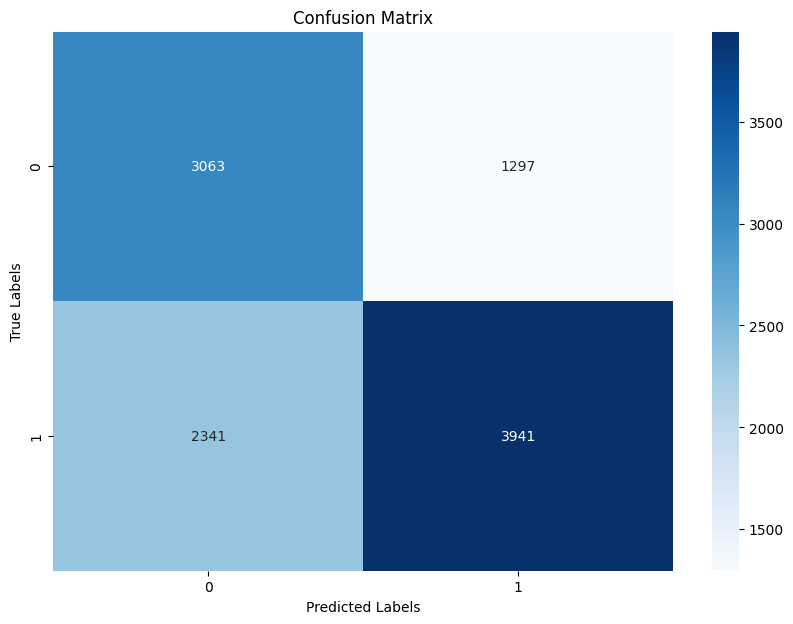


(TP + TN + FP) / Total: 78.0023


In [27]:
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import load

# Load the dataset
data = pd.read_csv('data_train_encode.csv')

# Ensure the dataset contains the 'Late' column for labels
if 'Late' not in data.columns:
    raise ValueError("The dataset must contain the 'Late' column for labels")

# Split the dataset into features and labels
X = data.drop('Late', axis=1)
y = data['Late']

# Load the trained model pipeline
loaded_pipeline = load("model_dt_new.joblib")

# Make predictions on the entire dataset
predictions = loaded_pipeline.predict(X)

# Compute the confusion matrix
conf_matrix = confusion_matrix(y, predictions)

# Print the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

# Calculate percentages
total_predictions = conf_matrix.sum()
correct_predictions = conf_matrix[0, 0] + conf_matrix[1, 1]
incorrect_predictions = total_predictions - correct_predictions

correct_percentage = (correct_predictions / total_predictions) * 100
incorrect_percentage = (incorrect_predictions / total_predictions) * 100

print(f"\nTotal predictions: {total_predictions}")
print(f"Correct predictions: {correct_predictions} ({correct_percentage:.2f}%)")
print(f"Incorrect predictions: {incorrect_predictions} ({incorrect_percentage:.2f}%)")

# Calculate On-time Delivery Rate
true_negatives = conf_matrix[0, 0]
false_positives = conf_matrix[0, 1]
on_time_delivery_rate = (true_negatives / (true_negatives + false_positives)) * 100

print(f"On-time Delivery Rate: {on_time_delivery_rate:.2f}%")

# Print classification report
print("\nClassification Report:")
print(classification_report(y, predictions))

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Calculate the individual components from the confusion matrix
tn = conf_matrix[0, 0]
fp = conf_matrix[0, 1]
fn = conf_matrix[1, 0]
tp = conf_matrix[1, 1]

# Calculate the required value
required_value = ((tp + tn + fp) / total_predictions) * 100

# Print the result
print(f"\n(TP + TN + FP) / Total: {required_value:.4f}")


[0.56557715]
